In [30]:
import pandas as pd, requests, time
import numpy as np

import datetime
import geopy
from geopy.geocoders import GoogleV3

import shapefile as shp
from shapely.geometry import Point, Polygon

import pyproj
from pyproj import CRS

import folium
from folium.plugins import MarkerCluster, HeatMapWithTime

from IPython.display import display_html

import seaborn as sns
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')


def number_to_monthName(num):
    return ["January","February","March","April","May","June","July","August","September","October","November","December"][num - 1]
def number_to_weekday(num):
    return ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"][num]

month_order=['January','February','March','April','May','June','July','August','October','November','December']
days_order= ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

wijk_order=['Overdie','Oudorp','Centrum','Zuid','Huiswaard','De Mare','Daalmeer/Koedijk','Vroonermeer','West','Schermer','Graft-De Rijp']

In [31]:
class Cleaned_Data:
    # 2 data sources per year, two files per cleaning car(One for 2020 and the other for 2021)
    ndev = 2
    # allow indexing
    pos_20= [None] * ndev  
    pos_21= [None] * ndev
    
   # periods=['2020_Q1','2020_Q2','2020_Q3']
# I pass Q1 of 2020 to start with
def ravoEquipement_read_files(periods):
    for i in range(Cleaned_Data.ndev):
        if i == 0:
            ravo = 'Stadwerk072_5170'
        elif i == 1:
            ravo = 'Stadwerk072_5173'
        for period in periods:
            if period =='2020':
                Cleaned_Data.pos_20[i] = pd.read_csv('../ravo/'+ period +'/'+ ravo + '/cleaned_positions_with_wijk.csv',index_col='#')
            elif period == '2021':
                Cleaned_Data.pos_21[i] = pd.read_csv('../ravo/'+ period +'/'+ ravo + '/cleaned_positions_with_wijk.csv',index_col='#')
ravoEquipement_read_files(['2020','2021'])

In [32]:
def get_date_state_visited(df, name):
    date_list=[]
    states=[]
    name_list=[]
    for s in df.Equipment_status.sort_values().unique():
        states.append(s)
        name_list.append(name)
        dates=list(set(df.loc[df.Equipment_status == s, 'Timestamp'].values.tolist()))
        date_list.append(dates)
    new_df= pd.DataFrame(states, columns=['State'])
    new_df['Timestamp']= date_list
    new_df['Car_name']= name_list
    new_df= new_df.explode('Timestamp', ignore_index=True).dropna()
    new_df['Timestamp']=pd.to_datetime(new_df['Timestamp'])  
    new_df['year']=new_df['Timestamp'].apply(lambda x:x.year)
    new_df['month']=new_df['Timestamp'].apply(lambda x:number_to_monthName(x.month))
    new_df['week']=new_df['Timestamp'].apply(lambda x:x.week)
    new_df['weekday']=new_df['Timestamp'].apply(lambda x:number_to_weekday(x.weekday()))
    new_df['day']=new_df['Timestamp'].apply(lambda x:x.day)
    return new_df


def get_date_wijk_visited(df, name):
    date_list=[]
    wijk=[]
    name_list=[]
    for w in df.Wijk.sort_values().unique():
        wijk.append(w)
        name_list.append(name)
        dates=list(set(df.loc[df.Wijk == w, 'date'].values.tolist()))
        date_list.append(dates)
    new_df= pd.DataFrame(wijk, columns=['Wijk'])
    new_df['date']= date_list
    new_df['Car_name']= name_list
    new_df= new_df.explode('date', ignore_index=True)
    new_df['year']=new_df['date'].apply(lambda x:pd.to_datetime(x).year)
    new_df['month']=new_df['date'].apply(lambda x:number_to_monthName(pd.to_datetime(x).month))
    new_df['week']=new_df['date'].apply(lambda x:pd.to_datetime(x).week)
    new_df['weekday']=new_df['date'].apply(lambda x:number_to_weekday(pd.to_datetime(x).weekday()))
    new_df['day']=new_df['date'].apply(lambda x:pd.to_datetime(x).day)
    return new_df

In [67]:
def plotInitData(df,time):
    g = sns.catplot(x="Wijk", data= df, row=time,col='Equipment_name',order = df['Wijk'].value_counts().index, kind="count",
                height=8, aspect=1)
    g.set_xticklabels(rotation=40, ha='right')
    g.fig.subplots_adjust(top=.9)
    g.fig.suptitle("Number of times the sweeper(s) visited each Neiborhood per {}".format(time))
    
# Function to plot sweeper data per period time. Arguments: df, period, plots column setup
def plotSweeperDataPerTime(df,time, col_choice): 
    if(time =='year'):
        if(col_choice == 'Car_name'):
            g = sns.catplot(x='Wijk', data= df,col='Car_name', sharex='row',order = wijk_order, kind="count", palette='husl')
            g.set_xticklabels(rotation=40, ha='right')
        else:
            g = sns.catplot(x='Wijk', data= df,col=time, sharex='row',order = wijk_order, kind="count", palette='husl')
            g.set_xticklabels(rotation=40, ha='right')
    elif(time =='month'):
        g = sns.catplot(x='Wijk', data= df, hue='weekday',col= time, sharey='col',col_order= month_order, order = days_order, kind='count', palette='husl')
        g.set_xticklabels(rotation=40, ha='right').set(ylim=(0, 7))
    elif(time =='weekday'):
        g = sns.catplot(x='Wijk', data= df,row='Car_name',col= time, sharex='row',sharey='col', col_order= days_order, order = wijk_order, kind='count', palette='husl', height=6, aspect=.9)
        g.set_xticklabels(rotation=40, ha='right').set(ylim=(0, 35))
    else:
        g = sns.catplot(x='Wijk', data= df,col= time, order = wijk_order, kind="count")
    g.fig.subplots_adjust(top=1.8)
  #  g.fig.suptitle("Number of days Sweepers visited each Neiborhood in {}".format(df[time][0]))
    return g

In [58]:
# USing clear names and merge Positions datasets based on sweeper and based on year

Car_5170_year_2020= Cleaned_Data.pos_20[0]
Car_5170_year_2021= Cleaned_Data.pos_21[0]
Car_5173_year_2020= Cleaned_Data.pos_20[1]
Car_5173_year_2021= Cleaned_Data.pos_21[1]

# Based on the sweeper
Car_5170_2020_and_2021=Car_5170_year_2020.append(Car_5170_year_2021, ignore_index=True)
Car_5173_2020_and_2021=Car_5173_year_2020.append(Car_5173_year_2021, ignore_index=True)

# Based on the year
both_car_2020=Car_5170_year_2020.append(Car_5173_year_2020,ignore_index=True)
both_car_2021=Car_5170_year_2021.append(Car_5173_year_2021,ignore_index=True)

# Merge all sensor data, we may not need this
bothCars_bothYears=both_car_2020.append(both_car_2021,ignore_index=True)

In [59]:
df=get_date_state_visited(Car_5170_year_2020,'5170')

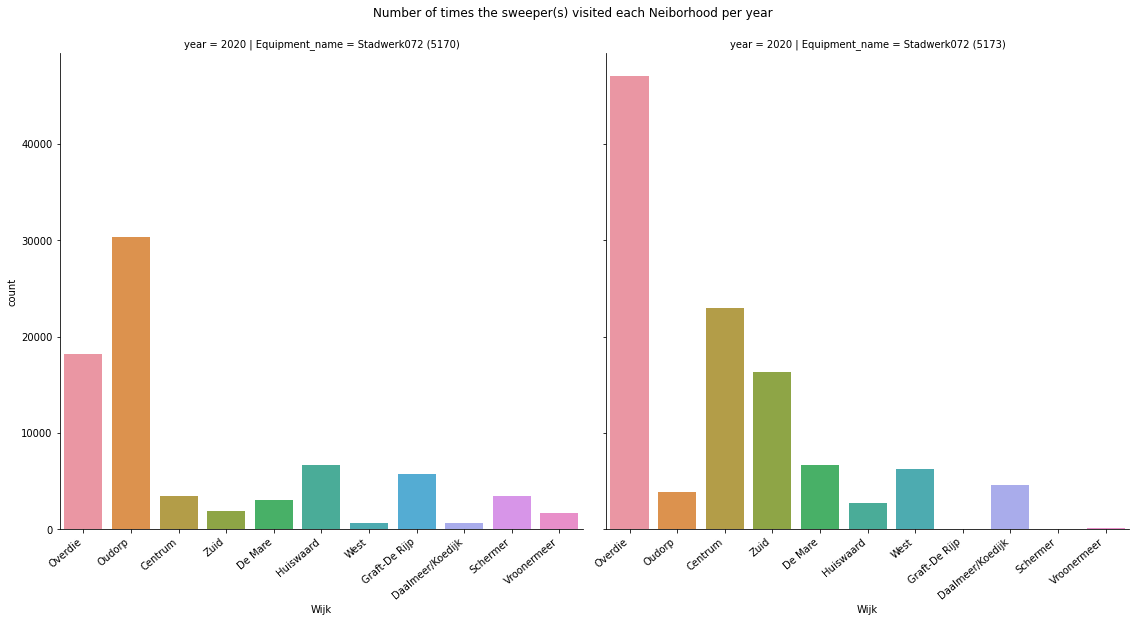

In [60]:
plotInitData(both_car_2020, 'year')

In [61]:
Wijk_visited_Car70_2020= get_date_wijk_visited(Car_5170_year_2020,'5170')
Wijk_visited_Car73_2020= get_date_wijk_visited(Car_5173_year_2020,'5173')
Wijk_visited_Car70_2021= get_date_wijk_visited(Car_5170_year_2021,'5170')
Wijk_visited_Car73_2021= get_date_wijk_visited(Car_5173_year_2021,'5173')
Wijk_visited_Car70_2020_2021= get_date_wijk_visited(Car_5170_2020_and_2021,'5170')
Wijk_visited_Car73_2020_2021= get_date_wijk_visited(Car_5173_2020_and_2021,'5173')

In [62]:
both_cars_2020=Wijk_visited_Car70_2020.append(Wijk_visited_Car73_2020, ignore_index=True).sort_values(by=['date'])

###### The numbers above are a bit misguiding, It compares the count of rows a neighborhood occurs in the data. We are interested with how many times a Ravo car visited/cleaned a neighborhood.
###### So let's count a neighborhood only once per date.

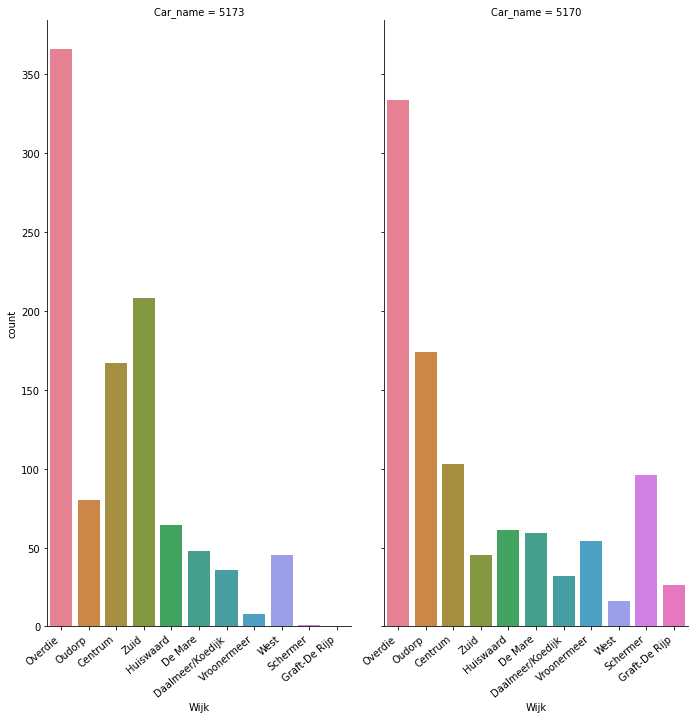

In [68]:
plotSweeperDataPerTime(both_cars_2020, 'year', 'Car_name')

##### From the plot above we can see atleast how many days per a given time a car drove in a neighborhood, however, it could be that sweepers were passing not cleaning. Let's get number of days each district was cleaned

In [64]:
sweeping_events_5170_20=Car_5170_year_2020[(Car_5170_year_2020.Equipment_status == 'HIGH Working') | (Car_5170_year_2020.Equipment_status == 'Working')]
sweeping_events_5173_20=Car_5173_year_2020[(Car_5173_year_2020.Equipment_status == 'HIGH Working') | (Car_5173_year_2020.Equipment_status == 'Working')]
sweeping_events_5170_21=Car_5170_year_2021[(Car_5170_year_2021.Equipment_status == 'HIGH Working') | (Car_5170_year_2021.Equipment_status == 'Working')]
sweeping_events_5173_21=Car_5173_year_2021[(Car_5173_year_2021.Equipment_status == 'HIGH Working') | (Car_5173_year_2021.Equipment_status == 'Working')]

Car70_wijk_cleaning_2020= get_date_wijk_visited(sweeping_events_5170_20, "5170")
Car73_wijk_cleaning_2020= get_date_wijk_visited(sweeping_events_5173_20, "5173")
Car70_wijk_cleaning_2021= get_date_wijk_visited(sweeping_events_5170_21, "5170")
Car73_wijk_cleaning_2021= get_date_wijk_visited(sweeping_events_5173_21, "5173")

bothCars_Wijk_cleaning_2020= Car70_wijk_cleaning_2020.append(Car73_wijk_cleaning_2020, ignore_index=True).sort_values(by=['date'])
bothCars_Wijk_cleaning_2021= Car70_wijk_cleaning_2021.append(Car73_wijk_cleaning_2021, ignore_index=True).sort_values(by=['date'])


Car70_both_years=Car70_wijk_cleaning_2020.append(Car70_wijk_cleaning_2021, ignore_index=True).sort_values(by=['date'])  
Car73_both_years=Car73_wijk_cleaning_2020.append(Car73_wijk_cleaning_2021, ignore_index=True).sort_values(by=['date']) 

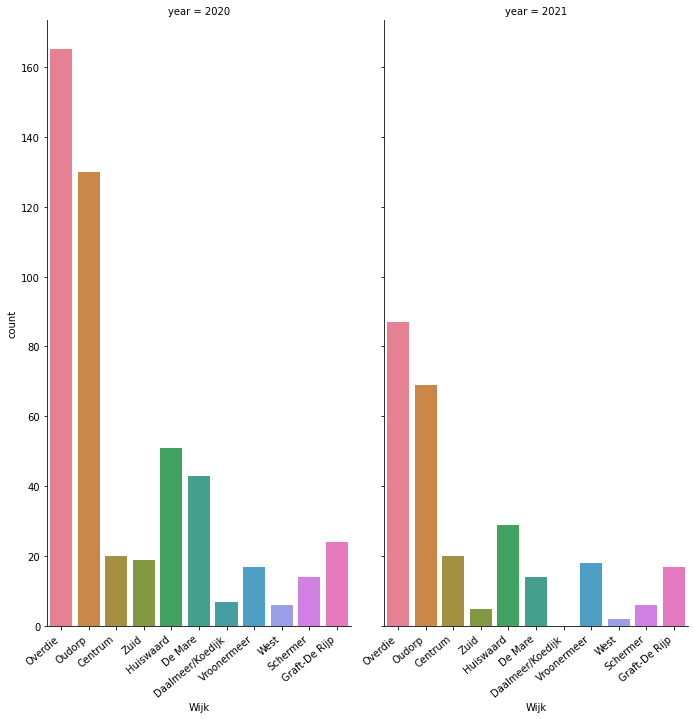

In [69]:
plotSweeperDataPerTime(Car70_both_years, 'year', 'year')

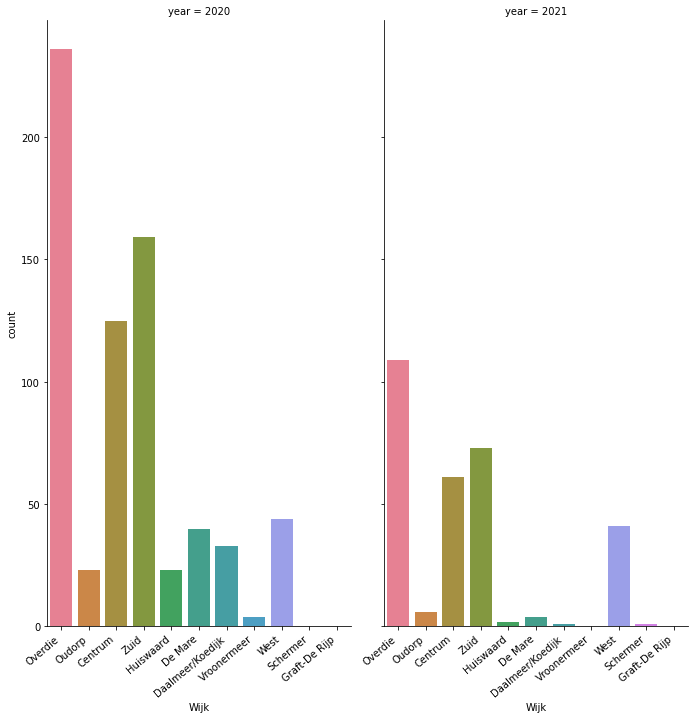

In [70]:
plotSweeperDataPerTime(Car73_both_years, 'year', 'year')

In [71]:
# Helper function for setting data to show as a table, it takes a dataframe as parameter and it should contain columns labels: date, WK_NAAM and Time_cleaned

def get_nbr_visited(df):
    date_list=[]
    wijk=[]
    number_of_days=[]
    for w in df.Wijk.sort_values().unique():
        wijk.append(w)
        dates=list(set(df.loc[df.Wijk == w, 'date'].values.tolist()))
        date_list.append(dates)
        number_of_days.append(len(dates))
    newdf= pd.DataFrame(list(zip(wijk, number_of_days)),columns =['WK_NAAM', 'Time_cleaned']) 
    return newdf    
     

##### Excluding Overdie from analysis and generating tables with number of days a district was cleaned

In [112]:
Car70_wijk_cleaning_2020=Car70_wijk_cleaning_2020[Car70_wijk_cleaning_2020['Wijk'] != 'Overdie']
Car73_wijk_cleaning_2020=Car73_wijk_cleaning_2020[Car73_wijk_cleaning_2020['Wijk'] != 'Overdie']
Car70_wijk_cleaning_2021=Car70_wijk_cleaning_2021[Car70_wijk_cleaning_2021['Wijk'] != 'Overdie']
Car73_wijk_cleaning_2021=Car73_wijk_cleaning_2021[Car73_wijk_cleaning_2021['Wijk'] != 'Overdie']

In [113]:
times_wijk_sweept7020=get_nbr_visited(Car70_wijk_cleaning_2020).sort_values(by=['Time_cleaned'], ascending=False)
times_wijk_sweept7320=get_nbr_visited(Car73_wijk_cleaning_2020).sort_values(by=['Time_cleaned'], ascending=False)
times_wijk_sweept7021=get_nbr_visited(Car70_wijk_cleaning_2021).sort_values(by=['Time_cleaned'], ascending=False)
times_wijk_sweept7321=get_nbr_visited(Car73_wijk_cleaning_2021).sort_values(by=['Time_cleaned'], ascending=False)

In [120]:
time_cleaned_table2020=times_wijk_sweept7020.join(times_wijk_sweept7320.set_index('WK_NAAM'),on='WK_NAAM',lsuffix='70',rsuffix='73').fillna(0)
time_cleaned_table2020['Time_cleaned']= time_cleaned_table2020.sum(axis=1, numeric_only=True).astype(int)
time_cleaned_table2020['Time_cleaned73']=time_cleaned_table2020['Time_cleaned73'].astype(int)
time_cleaned_table2020=time_cleaned_table2020.sort_values(by=['Time_cleaned'], ascending=False)

In [121]:
time_cleaned_table2021=times_wijk_sweept7021.join(times_wijk_sweept7321.set_index('WK_NAAM'),on='WK_NAAM',lsuffix='70',rsuffix='73').fillna(0)
time_cleaned_table2021['Time_cleaned']= time_cleaned_table2021.sum(axis=1, numeric_only=True).astype(int)
time_cleaned_table2021['Time_cleaned73']=time_cleaned_table2021['Time_cleaned73'].astype(int)
time_cleaned_table2021=time_cleaned_table2021.sort_values(by=['Time_cleaned'], ascending=False)

In [122]:
from IPython.display import display_html 

df1_style = time_cleaned_table2020.style.set_table_attributes("style='display:inline; margin-right:20px;'").set_caption(" RAVO 5173 and 5170 in year 2020")
df2_style = time_cleaned_table2021.style.set_table_attributes("style='display:inline'").set_caption(" RAVO 5173 and 5170 in first half 2021")

display_html(df1_style._repr_html_() + df2_style._repr_html_(), raw=True)

,WK_NAAM,Time_cleaned70,Time_cleaned73,Time_cleaned
9,Zuid,19,159,178
5,Oudorp,130,23,153
0,Centrum,20,125,145
2,De Mare,43,40,83
4,Huiswaard,51,23,74
8,West,6,44,50
1,Daalmeer/Koedijk,7,33,40
3,Graft-De Rijp,24,0,24
7,Vroonermeer,17,4,21
6,Schermer,14,0,14


In [183]:
bothCars_time_cleaned_2020=get_nbr_visited(bothCars_Wijk_cleaning_2020).sort_values(by=['Time_cleaned'], ascending=False)

In [185]:
bothCars_time_cleaned_2020

,WK_NAAM,Time_cleaned
6,Overdie,272
10,Zuid,169
5,Oudorp,145
0,Centrum,139
2,De Mare,82
4,Huiswaard,72
9,West,48
1,Daalmeer/Koedijk,40
3,Graft-De Rijp,24
8,Vroonermeer,21


###### Use ARCGIS data to get more statistical data for districts

In [182]:

import geopandas as gpd

geoData = gpd.read_file('https://services9.arcgis.com/7e6lF03RcLhwFtm5/arcgis/rest/services/Wijken/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json')


In [187]:
Alk_wijken=geoData[geoData.GM_NAAM == 'Alkmaar']
Alk_wijken= Alk_wijken[['WK_NAAM','AANT_INW','Shape__Length','Shape__Area','geometry']]
Alk_wijken['km2']=Alk_wijken['Shape__Area'] / 1000000
Alk_wijken.rename(columns = {'Shape__Area':'Area Size'}, inplace = True)

##### Merge with numbers district cleaned 

In [189]:
Alk_wijken=Alk_wijken=Alk_wijken.join(bothCars_time_cleaned_2020.set_index('WK_NAAM'),on='WK_NAAM')

##### Check relation between features

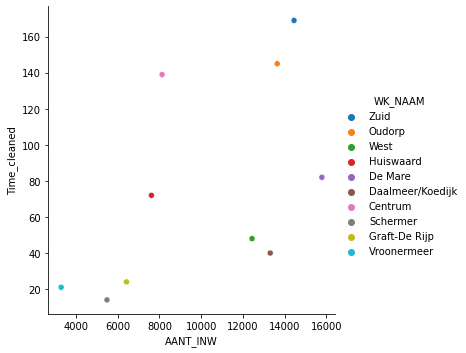

In [192]:
df_drop_overdie=Alk_wijken[Alk_wijken['WK_NAAM'] !='Overdie']
sns.relplot(x="AANT_INW", y="Time_cleaned",hue="WK_NAAM",data=df_drop_overdie);

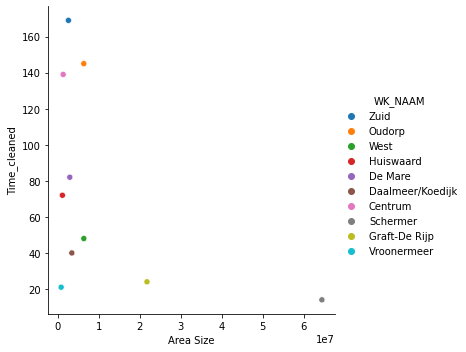

In [194]:
sns.relplot(x="Area Size", y="Time_cleaned",hue="WK_NAAM",data=df_drop_overdie);

##### Visualization using folium maps

In [180]:
Alk_wijken.explore(
     column="WK_NAAM",  # make choropleth based on "BoroName" column
     scheme="naturalbreaks",  # use mapclassify's natural breaks scheme
     legend=True, # show legend
     k=10, # use 10 bins
     legend_kwds=dict(colorbar=False), # do not use colorbar
     name="WK_NAAM" # name of the layer in the map
)

##### Visualization of different features and compare their relations

In [202]:
import folium

def generate_choropleth(geodata, data_field):
    style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}
    highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}

    m = folium.Map(location = [52.61,4.76], zoom_start = 11)
        
    folium.Choropleth(
        geo_data=geodata,
        name='choropleth',
        data=geodata,
        columns=['WK_NAAM', data_field],
        key_on='feature.properties.WK_NAAM',
        fill_color='YlOrRd',
        fill_opacity=0.7,
        line_opacity=.1,
        legend_name=data_field,
     ).add_to(m)

    wijkNames = folium.features.GeoJson(
               data = geodata,
               style_function=style_function, 
               control=False,
               highlight_function=highlight_function, 
               tooltip=folium.features.GeoJsonTooltip(
                       fields=['WK_NAAM','Time_cleaned', 'AANT_INW','Area Size'],
                       aliases=['District Name','Cleaned days','Nbr Inhabitant', 'Shape Area'],
                       style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;"),
                   labels=True
                ),
     )
    m.add_child(wijkNames)
    m.keep_in_front(wijkNames)

    folium.TileLayer('Stamen Toner', control=True).add_to(m)  # add alternative tiles
    folium.LayerControl().add_to(m)
    return m



In [204]:
generate_choropleth(Alk_wijken, 'AANT_INW')

In [203]:
generate_choropleth(Alk_wijken, 'Time_cleaned')

In [205]:
generate_choropleth(Alk_wijken, 'Area Size')